In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statistics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('../data/final_data.csv')
df = df.fillna(0)

In [3]:
target_discipline = "combined"

In [4]:
# Determine target and features based on discipline
if target_discipline == 'boulder':
    y = df['boulder_points']
    # Use other disciplines as features
    discipline_features = ['lead_points', 'combined_points']
elif target_discipline == 'lead':
    y = df['lead_points']
    discipline_features = ['boulder_points', 'combined_points']
else:  # combined
    y = df['combined_points']
    discipline_features = ['boulder_points', 'lead_points']

# Create base feature set (excluding targets)
X = df.drop(['boulder_points', 'lead_points', 'combined_points', "name", "country", "gender"], axis=1)

# Add back the relevant discipline features
for feature in discipline_features:
    X[feature] = df[feature]

In [5]:
# One‑hot‑encode the 'country' column
country_dummies = pd.get_dummies(df['country'], prefix='country')

# Concatenate the dummies with the existing feature matrix
X = pd.concat([X, country_dummies], axis=1)

In [6]:
# Calculate baseline metrics
rmse_mean_baseline = np.std(y)
print(f"RMSE of a 'mean guess' baseline model: {rmse_mean_baseline:.2f}")

RMSE of a 'mean guess' baseline model: 879.60


In [8]:
linreg = LinearRegression()
# 5-Fold Cross-validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kf5 = cross_val_score(linreg, X, y, cv=kf5, scoring="neg_mean_squared_error")
mean_rmse_kf5 = statistics.mean(np.sqrt(np.abs(scores_kf5)))
print(f"Mean RMSE from 5-Fold CV with Linear Regression: {mean_rmse_kf5:.2f}")

# 10-Fold Cross-validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_kf10 = cross_val_score(linreg, X, y, cv=kf10, scoring="neg_mean_squared_error")
mean_rmse_kf10 = statistics.mean(np.sqrt(np.abs(scores_kf10)))
print(f"Mean RMSE from 10-Fold CV with Linear Regression: {mean_rmse_kf10:.2f}")

Mean RMSE from 5-Fold CV with Linear Regression: 449.02
Mean RMSE from 10-Fold CV with Linear Regression: 450.43


In [9]:
loo = LeaveOneOut()
scores_loo = cross_val_score(linreg, X, y, cv = loo, scoring = "neg_mean_squared_error")
print(f"Mean RMSE from LOO with Linear Regression: {statistics.mean(np.sqrt(np.abs(scores_loo))):.2f}")

Mean RMSE from LOO with Linear Regression: 223.03


In [11]:
# Fit and evaluate on full dataset
linreg.fit(X, y)
y_pred_linear = linreg.predict(X)
rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
print(f"RMSE on full dataset with Linear Regression: {rmse_linear:.2f}")

RMSE on full dataset with Linear Regression: 418.58


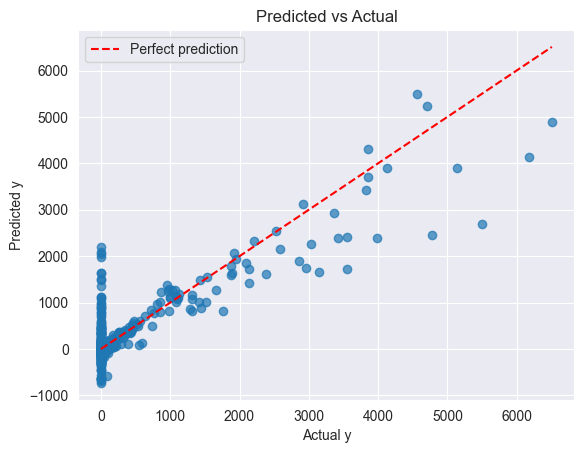

In [12]:
linreg.fit(X, y)
y_pred = linreg.predict(X)
# Plot
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Define model
xgb_clf = xgb.XGBRegressor(eval_metric='rmse', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Grid search with cross-validation
grid = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, y)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validated RMSE: {np.sqrt(np.abs(grid.best_score_)):.2f}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validated RMSE: 343.01


In [14]:
xgb_best = xgb.XGBRegressor(eval_metric='rmse', random_state=42, **grid.best_params_)

In [15]:
# 5-Fold Cross-validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kf5 = cross_val_score(xgb_best, X, y, cv=kf5, scoring="neg_mean_squared_error")
mean_rmse_kf5 = statistics.mean(np.sqrt(np.abs(scores_kf5)))
print(f"Mean RMSE from 5-Fold CV with XGBoost: {mean_rmse_kf5:.2f}")

# 10-Fold Cross-validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_kf10 = cross_val_score(xgb_best, X, y, cv=kf10, scoring="neg_mean_squared_error")
mean_rmse_kf10 = statistics.mean(np.sqrt(np.abs(scores_kf10)))
print(f"Mean RMSE from 10-Fold CV with XGBoost: {mean_rmse_kf10:.2f}")

Mean RMSE from 5-Fold CV with Linear Regression: 347.33
Mean RMSE from 10-Fold CV with Linear Regression: 297.63


In [16]:
loo_xgb = LeaveOneOut()
scores_loo_xgb = cross_val_score(xgb_best, X, y, cv=loo_xgb, scoring='neg_mean_squared_error')

# Calculate and print the RMSE (Root Mean Squared Error) from LOO
rmse_loo_xgb = np.sqrt(np.abs(scores_loo_xgb))
print(f"Mean RMSE from LOO with Best XGBoost Parameters: {statistics.mean(rmse_loo_xgb):.2f}")

Mean RMSE from LOO with Best XGBoost Parameters: 88.45


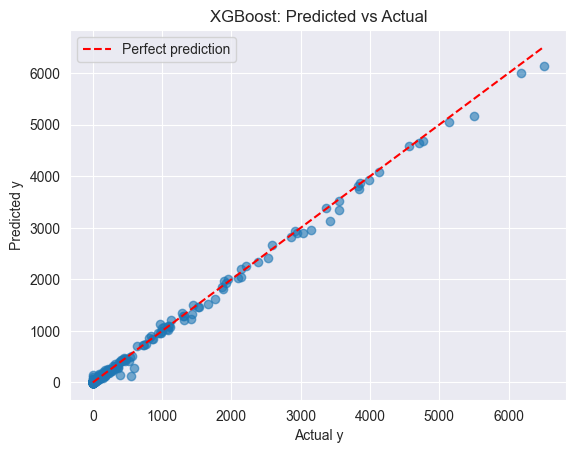

In [17]:
xgb_best.fit(X, y)
y_pred = xgb_best.predict(X)

plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('XGBoost: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Get a text representation of the model
dump = xgb_best.get_booster().get_dump()

n = grid.best_params_['n_estimators']
# Print the first tree
print("Last tree representation:")
print(dump[n-1])

Last tree representation:
0:[boulder_points<893] yes=1,no=2,missing=2
	1:[count_8c_plus<26] yes=3,no=4,missing=4
		3:[boulder_points<644] yes=7,no=8,missing=8
			7:[boulder_points<618] yes=15,no=16,missing=16
				15:[boulder_points<267.5] yes=29,no=30,missing=30
					29:leaf=-0.116208725
					30:leaf=0.460100025
				16:[lead_points<1] yes=31,no=32,missing=32
					31:leaf=-0.199691638
					32:leaf=4.18633842
			8:[lead_points<1291] yes=17,no=18,missing=18
				17:[lead_points<554.5] yes=33,no=34,missing=34
					33:leaf=-0.543212831
					34:leaf=-3.99572444
				18:leaf=1.70027471
		4:[boulder_points<111] yes=9,no=10,missing=10
			9:[highest_grade<28] yes=19,no=20,missing=20
				19:leaf=-0.676678896
				20:leaf=0.726373315
			10:leaf=4.77981138
	2:[lead_points<2000] yes=5,no=6,missing=6
5:[country_USA] yes=11,no=12
			11:[lead_points<1] yes=21,no=22,missing=22
				21:[boulder_points<1995] yes=35,no=36,missing=36
					35:leaf=-0.0480924509
					36:leaf=-1.57113361
				22:[lead_points<78] ye

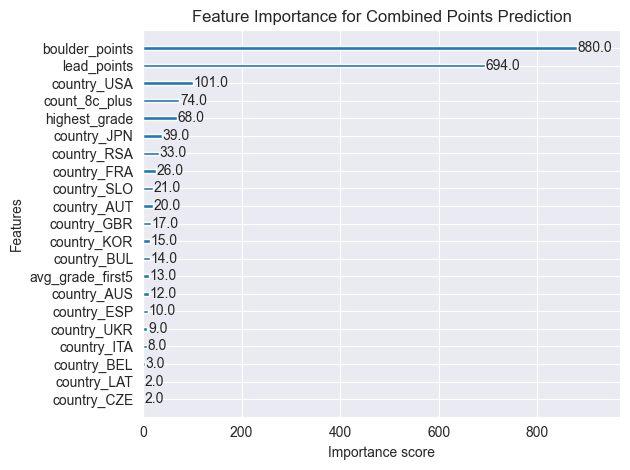

In [19]:
xgb.plot_importance(xgb_best)
plt.title(f"Feature Importance for {target_discipline.capitalize()} Points Prediction")
plt.tight_layout()
plt.show()

TO DO:
-
-